# Генерация систем непрерывных и дискретных СВ

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
def hist(vals, pdf, a, b, xlabel='x', bins=20):
    n = len(vals)
    _ = plt.figure(figsize=(9, 7))
    plt.hist(vals, bins, density=True, alpha=0.3, label='sample density')
    plt.plot(np.linspace(a, b, N), pdf(np.linspace(a, b, n)), label='pdf')
    plt.title(f'Histogram of {xlabel} sample')
    plt.ylabel('density')
    plt.xlabel(xlabel)
    plt.legend()
    plt.show()
    
def cint_mu(vals, alpha):
    n = len(vals)
    se = np.std(vals, ddof=1) / n**0.5
    t = st.t.ppf(1 - alpha/2, df=n-1)
    me = np.mean(vals)
    return me - t*se, me + t*se

def cint_var(vals, alpha):
    n = len(vals)
    sse = n*np.var(vals)
    left_boundary =  sse / st.chi2.ppf(1 - alpha/2, df=n-1)
    right_boundary = sse / st.chi2.ppf(alpha/2, df=n-1)
    return left_boundary, right_boundary

## 1. Continuous random variable

$$f(x, y) = \frac{1}{63\pi}(9-\sqrt{x^2+y^2})$$

$$x^2+y^2 <= 9$$

[PDF transform](https://www.cs.cornell.edu/courses/cs6630/2015fa/notes/pdf-transform.pdf):
$$f(x, y) = \frac{f(r, \phi)}{|J(r, \phi)|}$$
$J$ - Jacobian

Polar coordinates
$$x=rcos(\phi), y=rsin(\phi)$$
$$J(r, \phi) = r$$
<br>
$$f(r, \phi) = f(rcos(\phi), rsin(\phi))*r =>$$
$$f(r, \phi) = \frac{1}{63\pi}(9-r)r$$

<br>
<br>
$f(r)=\int_{0}^{2\pi} f(r, \phi) \,d\phi=\frac{2}{63}(9-r)r;\ \ \  F(r)=\int_{0}^{r} f(r) \,dr=\frac{2}{63}(\frac{9r^2}{2} - \frac{r^3}{3})$

$f(\phi)=\int_{0}^{3} f(r, \phi) \,dr=\frac{1}{2\pi};\ \ \ F(\phi)=\int_{0}^{\phi} f(\phi) \,d\phi=\frac{\phi}{2\pi}$

In [5]:
class ContinuousDist3:
    _mu_r = 27/14
    _mu_phi = np.pi
    _var_r = 297/70 - _mu_r**2
    _var_phi = np.pi**2/3
    
    def x(self, r, phi):
        """Transform polar coords in cartesian x."""
        return r*np.cos(phi)
    
    def y(self, r, phi):
        """Transform polar coords in cartesian y."""
        return r*np.sin(phi)
    
    def pdf_r(self, r):
        return (2/63)*(9-r)*r
    
    @np.vectorize
    def pdf_phi(phi):
        return 1/(2*np.pi)
    
    def pdf(self, x1, x2, cs='polar'):
        """Return the value of probability density function of given coords.

        cs: str
            coordinate system
            -polar
            -cart -- cartesian
        """
        if cs == 'polar':
            return (9-x1)*x1/(63*np.pi)
        elif cs == 'cart':
            return (9-(x1**2+y**2)**0.5)/(63*np.pi)
        else:
            raise ValueError("cs must be 'polar' or 'cart'")
    
    def cdf_r(self, r):
        return (9*r**2 - 2*r**3/3)/63
    
    def cdf_phi(self, phi):
        return phi/(2*np.pi)
    
    def mu_interval(self, vals, alpha):
        return cint_mu(vals, alpha)
    
    def var_interval(self, vals, alpha):
        return cint_var(vals, alpha)
    
    def expect(self):
        return self._mu_r, self._mu_phi
    
    def var(self):
        return self._var_r, self._var_phi
    
    def rand(self, size=None, method='inverse'):
        res = []
        if method == 'inverse':
            for _ in range(size):
                a = np.roots((-2, 27, 0, -189*np.random.rand()))[1], 2*np.pi*np.random.rand()
                res.append(a)
        elif method == 'neiman':
            while len(res) != size:
                x, y, z = np.random.rand(3)
                r, phi = 3*x, 2*np.pi*y
                if 4.5*z <= (9-r)*r / (63*np.pi):
                    res.append((r, phi))
        else: 
            raise ValueError('no such method')
        return res[0] if size is None else np.array(res)

In [6]:
dist = ContinuousDist3()

In [29]:
N = 10000
r_a, r_b = 0, 3
phi_a, phi_b = 0, 2*np.pi

In [100]:
rvars = dist.rand(N)

In [101]:
rvars

array([[2.01046863, 3.09059953],
       [2.34112434, 2.56053091],
       [0.81063792, 5.17297371],
       ...,
       [2.58647953, 4.3119962 ],
       [2.82623387, 3.70593536],
       [1.41326763, 1.31732425]])

### Density in cartesian coordinates

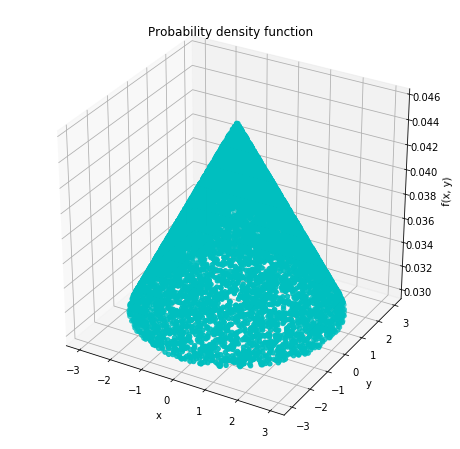

In [102]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
x = dist.x(rvars[:, 0], rvars[:, 1])
y = dist.y(rvars[:, 0], rvars[:, 1])
ax.scatter(x, y, dist.pdf(x, y, 'cart'), c='c')
plt.title('Probability density function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)', labelpad=8)
plt.show()

### Boxplot

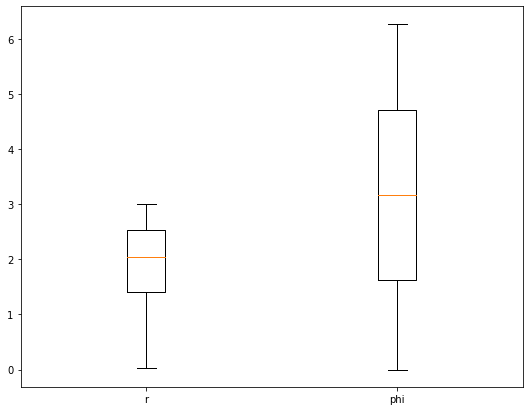

In [103]:
_ = plt.figure(figsize=(9, 7))
plt.boxplot(rvars, labels=['r', 'phi'])
plt.show()

### Histograms

#### r

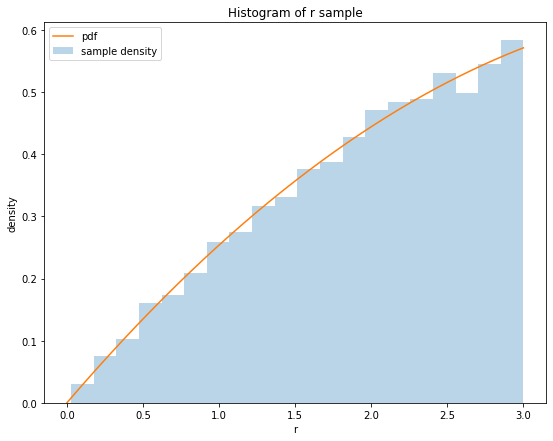

In [104]:
hist(rvars[:, 0], dist.pdf_r, r_a, r_b, 'r')

#### phi

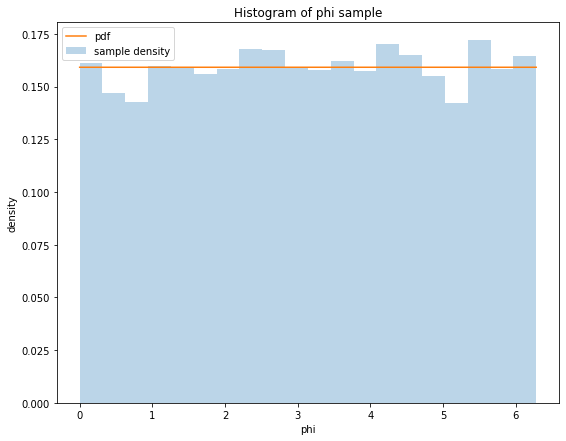

In [105]:
hist(rvars[:, 1], dist.pdf_phi, phi_a, phi_b, 'phi')

### Expected value

theoretical expected value (r, phi)

In [106]:
mu_r, mu_phi = dist.expect()
print(f'mu_r: {mu_r}, mu_phi: {mu_phi}')

mu_r: 1.9285714285714286, mu_phi: 3.141592653589793


emperical

In [107]:
mean_r, mean_phi = rvars.mean(axis=0)
print(f'mean_r: {mean_r}, mean_phi: {mean_phi}')

mean_r: 1.9310728443483698, mean_phi: 3.1672385037966317


#### Ttest

In [108]:
st.ttest_1samp(rvars, dist.expect())

Ttest_1sampResult(statistic=array([0.34541702, 1.4203046 ]), pvalue=array([0.72978815, 0.1555502 ]))

Don’t reject the null hypothesis that the expected value (mean) of a sample of independent observations rvars is equal to the given population mean.

#### confidence interval (95%) for the expected value with unknown variance

In [109]:
print(f'ci_mu_r: {dist.mu_interval(rvars[:, 0], 0.05)}\nci_mu_phi: {dist.mu_interval(rvars[:, 1], 0.05)}')

ci_mu_r: (1.9168776019731912, 1.9452680867235483)
ci_mu_phi: (3.1318439637086466, 3.20263304388463)


### Variance

theoretical variance (r, phi)

In [110]:
var_r, var_phi = dist.var()
print(f'var_r: {var_r}, var_phi: {var_phi}')

var_r: 0.5234693877551018, var_phi: 3.289868133696453


emperical unbiased

In [111]:
s2_r, s2_phi = rvars.var(axis=0, ddof=1)
print(f's2_r: {s2_r}, s2_phi: {s2_phi}')

s2_r: 0.5244260963942564, s2_phi: 3.2604024996647034


#### confidence interval (95%) for the variance

In [112]:
print(f'ci_var_r: {dist.var_interval(rvars[:, 0], 0.05)}\nci_var_phi: {dist.var_interval(rvars[:, 1], 0.05)}')

ci_var_r: (0.5101875660587021, 0.5392720007123402)
ci_var_phi: (3.1718803223421395, 3.3527007736851377)


### Correlation

In [113]:
np.corrcoef(rvars[:, 0], rvars[:, 1])

array([[ 1.        , -0.00477298],
       [-0.00477298,  1.        ]])

### KS test

r

In [114]:
st.kstest(rvars[:, 0], dist.cdf_r)

KstestResult(statistic=0.006568704193949948, pvalue=0.7812949432020806)

phi

In [115]:
st.kstest(rvars[:, 1], dist.cdf_phi)

KstestResult(statistic=0.010613561832702234, pvalue=0.20993277395675738)

Don’t reject equals distributions for r and $\phi$ with p-value = 0.05

## 2. Discrete random variable

$$f(x,y) = 2(x^2+\frac{y}{3}): 0≤x,y ≤1$$

$$F(x,y) = \int_0^x\int_0^y f(x,y)\, dxdy = \frac{xy(2x^2+y)}{3}$$

$$f(x) = \int_0^1 f(x,y)\, dy = 2(x^2 + \frac{1}{6});\ \  f(y) = \int_0^1 f(x,y)\, dx = \frac{2}{3}(1 + y)$$

<br>
Probability matrix

$P(a_1 <= X < a_2,b_1<=Y<b_2)=F(a_2,b_2)-F(a_1,b_2)-F(a_2,b_1)+F(a_1,b_1)$

In [46]:
class DiscreteDist5:
    def __init__(self, n=4):
        self.n = n
        # Compute probability matrix
        self.x_rv = np.linspace(0, 1, n)
        self.y_rv = np.linspace(0, 1, n)
        self.pr_matrix = np.zeros((n, n))
        for i in range(1, n):
            for j in range(1, n):
                self.pr_matrix[i, j] = (
                    self.cdf(self.x_rv[i], self.y_rv[j]) - self.cdf(self.x_rv[i-1], self.y_rv[j])
                    - self.cdf(self.x_rv[i], self.y_rv[j-1]) + self.cdf(self.x_rv[i-1], self.y_rv[j-1])
                )
        self._mu_x = sum(self.pr_matrix.sum(axis=1)*self.x_rv)
        self._mu_y = sum(self.pr_matrix.sum(axis=0)*self.y_rv)
        self._var_x = sum(self.pr_matrix.sum(axis=1)*self.x_rv**2) - self._mu_x**2
        self._var_y = sum(self.pr_matrix.sum(axis=0)*self.y_rv**2) - self._mu_y**2
    
    def pdf(self, x, y):
        return 2*(x**2 + y/3)
    
    def pdf_x(self, x):
        return 2*(x**2 + 1/6)
    
    def pdf_y(self, y):
        return 2*(1+y)/3
        
    def cdf(self, x, y):
        return x*y*(2*x**2+y)/3
    
    def mu_interval(self, vals, alpha):
        return cint_mu(vals, alpha)
    
    def var_interval(self, vals, alpha):
        return cint_var(vals, alpha)
    
    def expect(self):
        return self._mu_x, self._mu_y
    
    def var(self):
        return self._var_x, self._var_y
    
    def rand(self, size):
        if size is None:
            return self._random()
        else:
            return np.array([self._random() for _ in range(size)])
    
    def _random(self):
        x, y = np.random.rand(2)
        p = 0
        for i in range(self.n):
            for j in range(self.n):
                p += self.pr_matrix[i, j]
                if p > x:
                    return self.x_rv[i], self.y_rv[j]

In [47]:
N = 10000
dots_num = 6  # intervals = dots_nums - 1

In [48]:
discrete_dist = DiscreteDist5(dots_num)

In [49]:
discrete_dist.pr_matrix

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.00373333, 0.00906667, 0.0144    , 0.01973333,
        0.02506667],
       [0.        , 0.01013333, 0.01546667, 0.0208    , 0.02613333,
        0.03146667],
       [0.        , 0.02293333, 0.02826667, 0.0336    , 0.03893333,
        0.04426667],
       [0.        , 0.04213333, 0.04746667, 0.0528    , 0.05813333,
        0.06346667],
       [0.        , 0.06773333, 0.07306667, 0.0784    , 0.08373333,
        0.08906667]])

In [50]:
discrete_dist.pr_matrix.sum()

1.0

In [68]:
drvs = discrete_dist.rand(N)

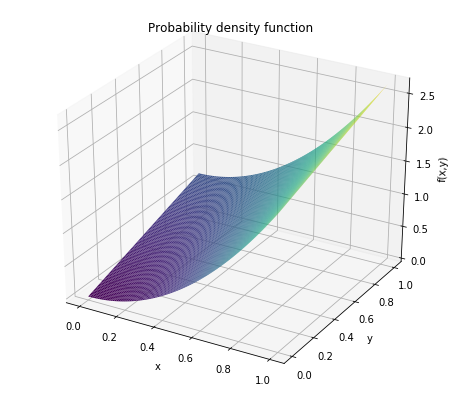

In [69]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
Z = discrete_dist.pdf(X, Y)

fig = plt.figure(figsize=(8, 7))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
ax.set_title('Probability density function');

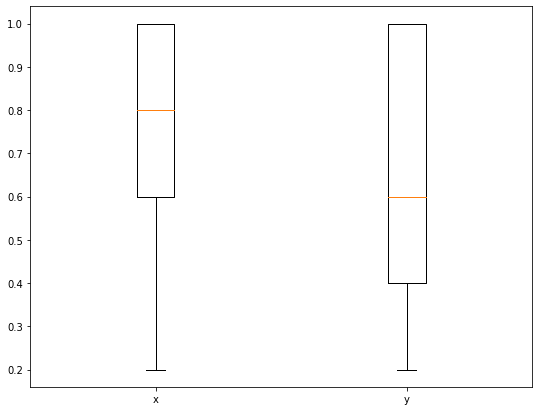

In [70]:
_ = plt.figure(figsize=(9, 7))
plt.boxplot(drvs, labels=['x', 'y'])
plt.show()

### Histograms

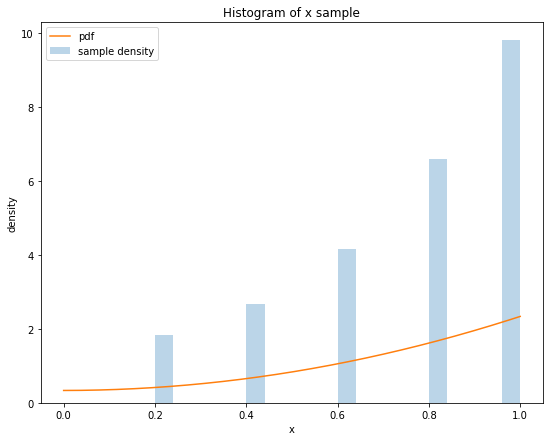

In [71]:
hist(drvs[:, 0], discrete_dist.pdf_x, 0, 1)

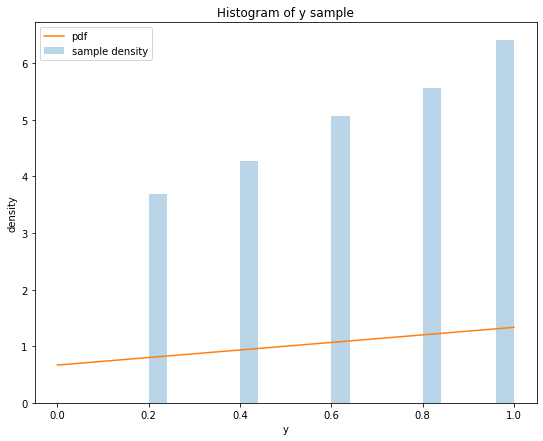

In [72]:
hist(drvs[:, 1], discrete_dist.pdf_y, 0, 1, 'y')

### Expected value (x, y)

theoretical

In [73]:
discrete_dist.expect()

(0.76, 0.6533333333333333)

point estimation

In [74]:
drvs.mean(axis=0)

array([0.75882, 0.65356])

#### Ttest

In [75]:
st.ttest_1samp(drvs, discrete_dist.expect())

Ttest_1sampResult(statistic=array([-0.46680591,  0.08142156]), pvalue=array([0.64064892, 0.93510834]))

Don’t reject the null hypothesis that the expected value (mean) of a sample of independent observations rvars is equal to the given population mean.

#### Confidence interval for the expected value with unknown variance

In [76]:
print(f'ci_mu_x: {discrete_dist.mu_interval(drvs[:, 0], 0.05)}\n'
    f'ci_mu_y: {discrete_dist.mu_interval(drvs[:, 1], 0.05)}')

ci_mu_x: (0.7538649695499912, 0.7637750304500089)
ci_mu_y: (0.6481030631500624, 0.6590169368499377)


### Variance (x, y)

theoretical

In [77]:
discrete_dist.var()

(0.06335999999999997, 0.07715555555555559)

point estimation

In [78]:
drvs.var(axis=0, ddof=1)

array([0.0638986 , 0.07749908])

#### Confidence interval for the variance

In [79]:
print(f'ci_var_x: {discrete_dist.var_interval(drvs[:, 0], 0.05)}\n'
    f'ci_var_y: {discrete_dist.var_interval(drvs[:, 1], 0.05)}')

ci_var_x: (0.06216370645301416, 0.06570749383326678)
ci_var_y: (0.07539492291677065, 0.07969298671657832)


### Correlation

In [80]:
np.corrcoef(drvs[:, 0], drvs[:, 1])

array([[ 1.        , -0.13226081],
       [-0.13226081,  1.        ]])

### Chi-square test

In [81]:
observed_frequences = np.unique(drvs[:, 0], return_counts=True)[1]
observed_frequences

array([ 730, 1063, 1659, 2632, 3916])

In [82]:
expected_frequences = discrete_dist.pr_matrix.sum(axis=1)[1:]*N
expected_frequences

array([ 720., 1040., 1680., 2640., 3920.])

In [83]:
st.chisquare(observed_frequences, expected_frequences, ddof=1)

Power_divergenceResult(statistic=0.9383667919382325, pvalue=0.8161605183470626)

We can't reject the null hypothesis that the generated sample is from the given distribution with p-value = 0.05